# HW03: due October th 

The goal of this homework is to **predict** the value of houses in California starting from house and neighborhood caracteristics. 

Differently from last week's homework, we are not interested in investigating the causal effect of some features on house values, but the main purpose is to obtain good predictions of the values, so to train the best model to minimize the loss function. 

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

In [2]:
# Load Data
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
print(data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [10]:
X_full, y_full = data.data, data.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]
print(n_samples,n_features)

20640 8


# Summary Statistics

In [12]:
X_df = pd.DataFrame(X_full, columns=data['feature_names'])

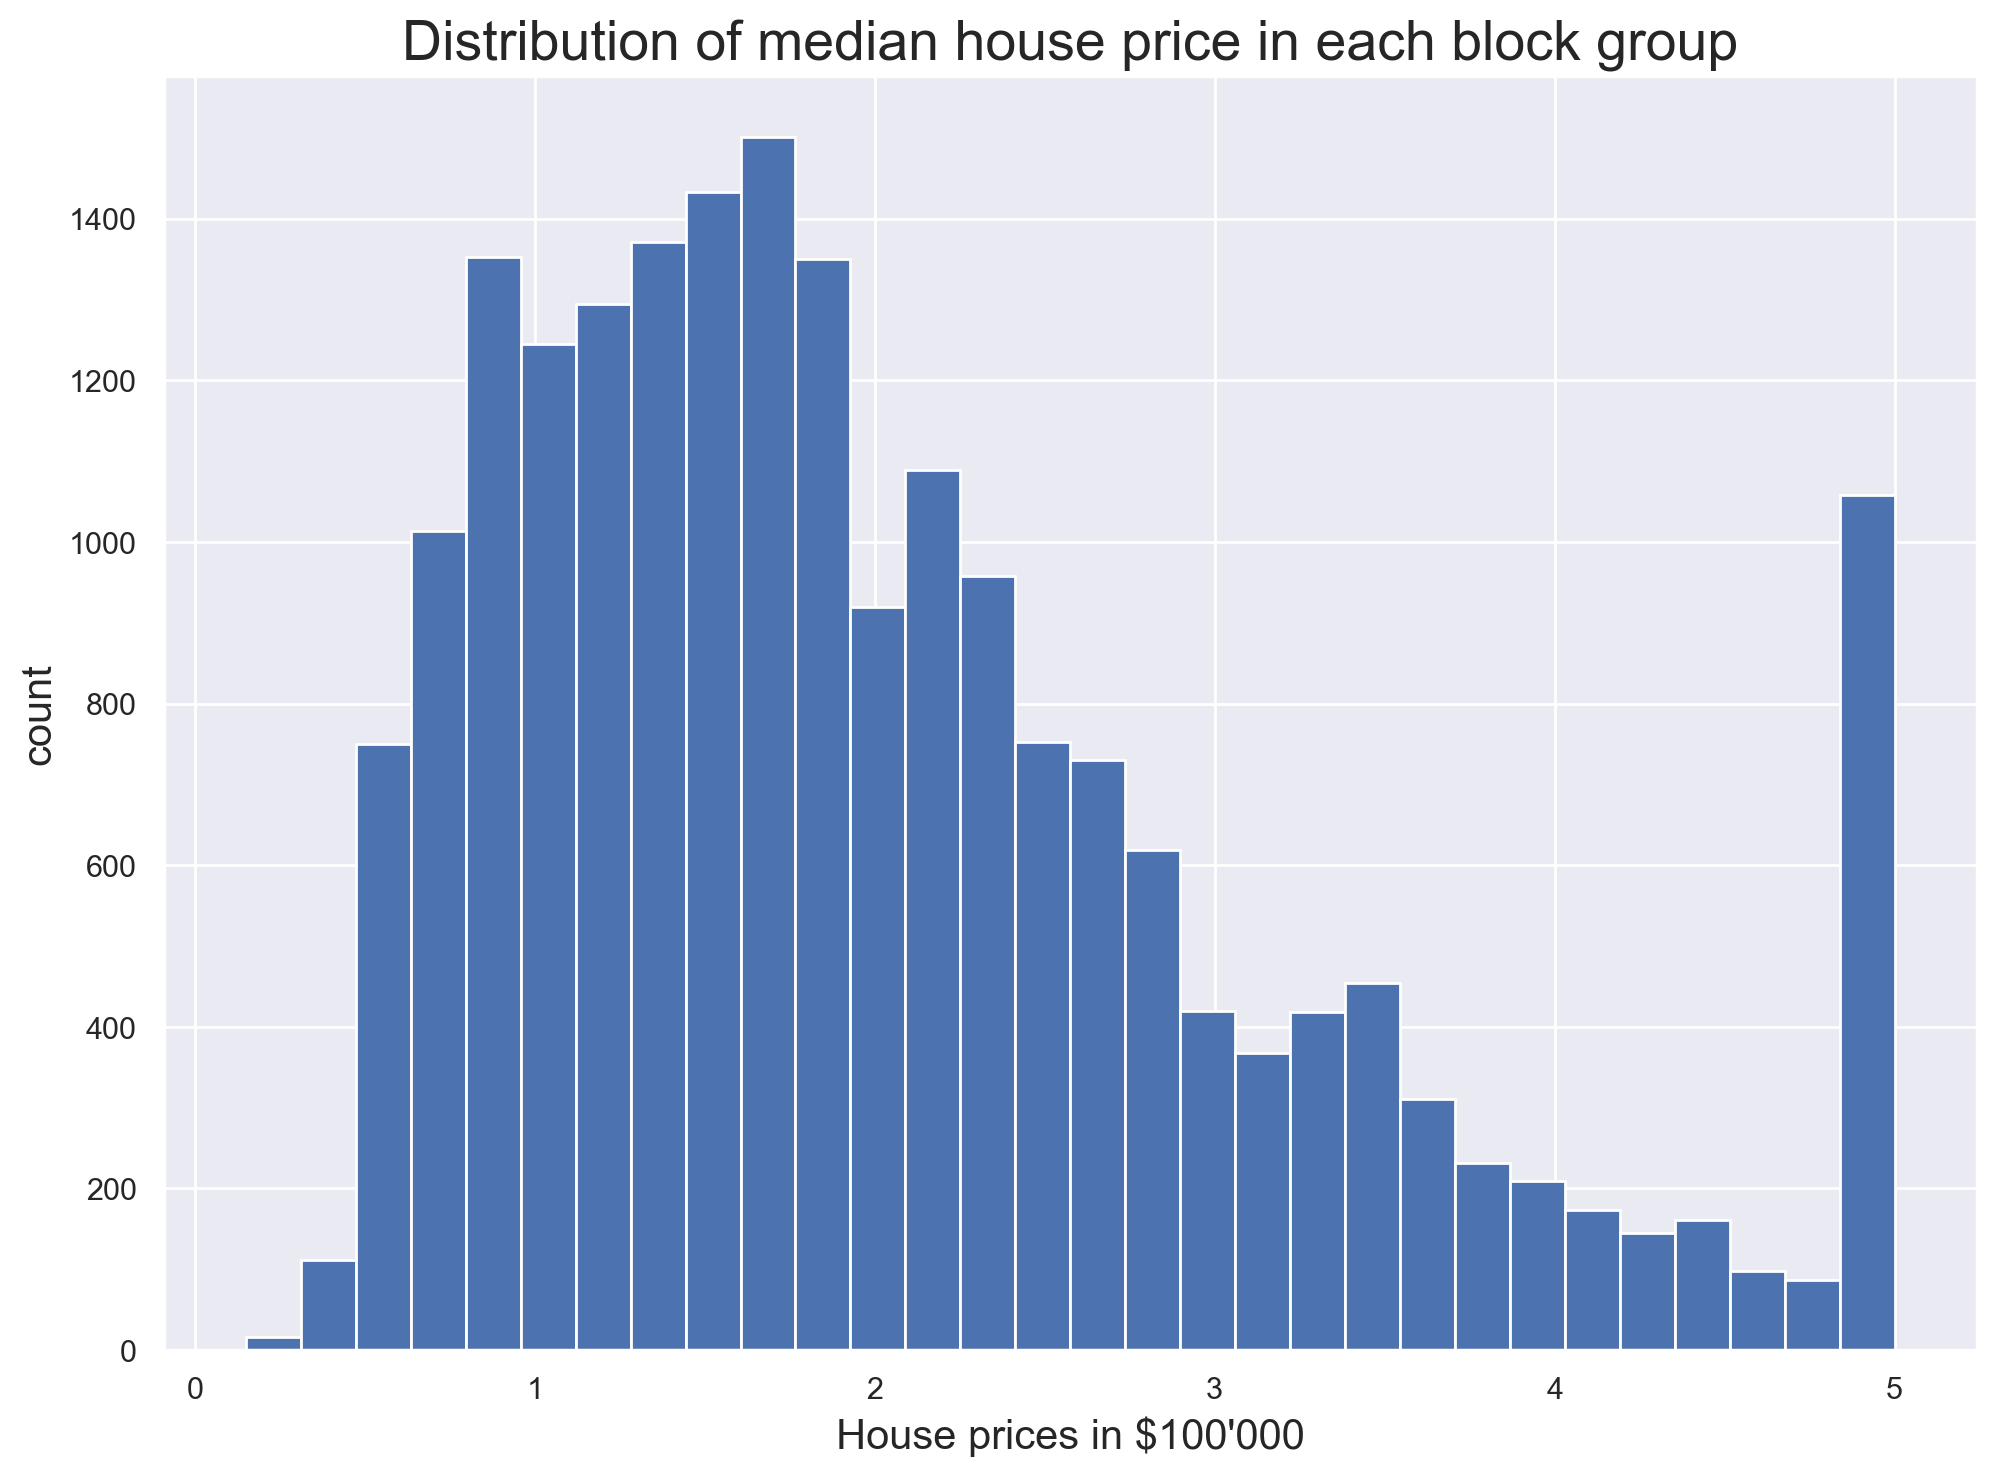

In [13]:
# make a histogram of the label variable ->> this is the thing we're predicting.

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(y_full, bins=30)
plt.xlabel("House prices in $100'000", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of median house price in each block group', size=20)
plt.show()

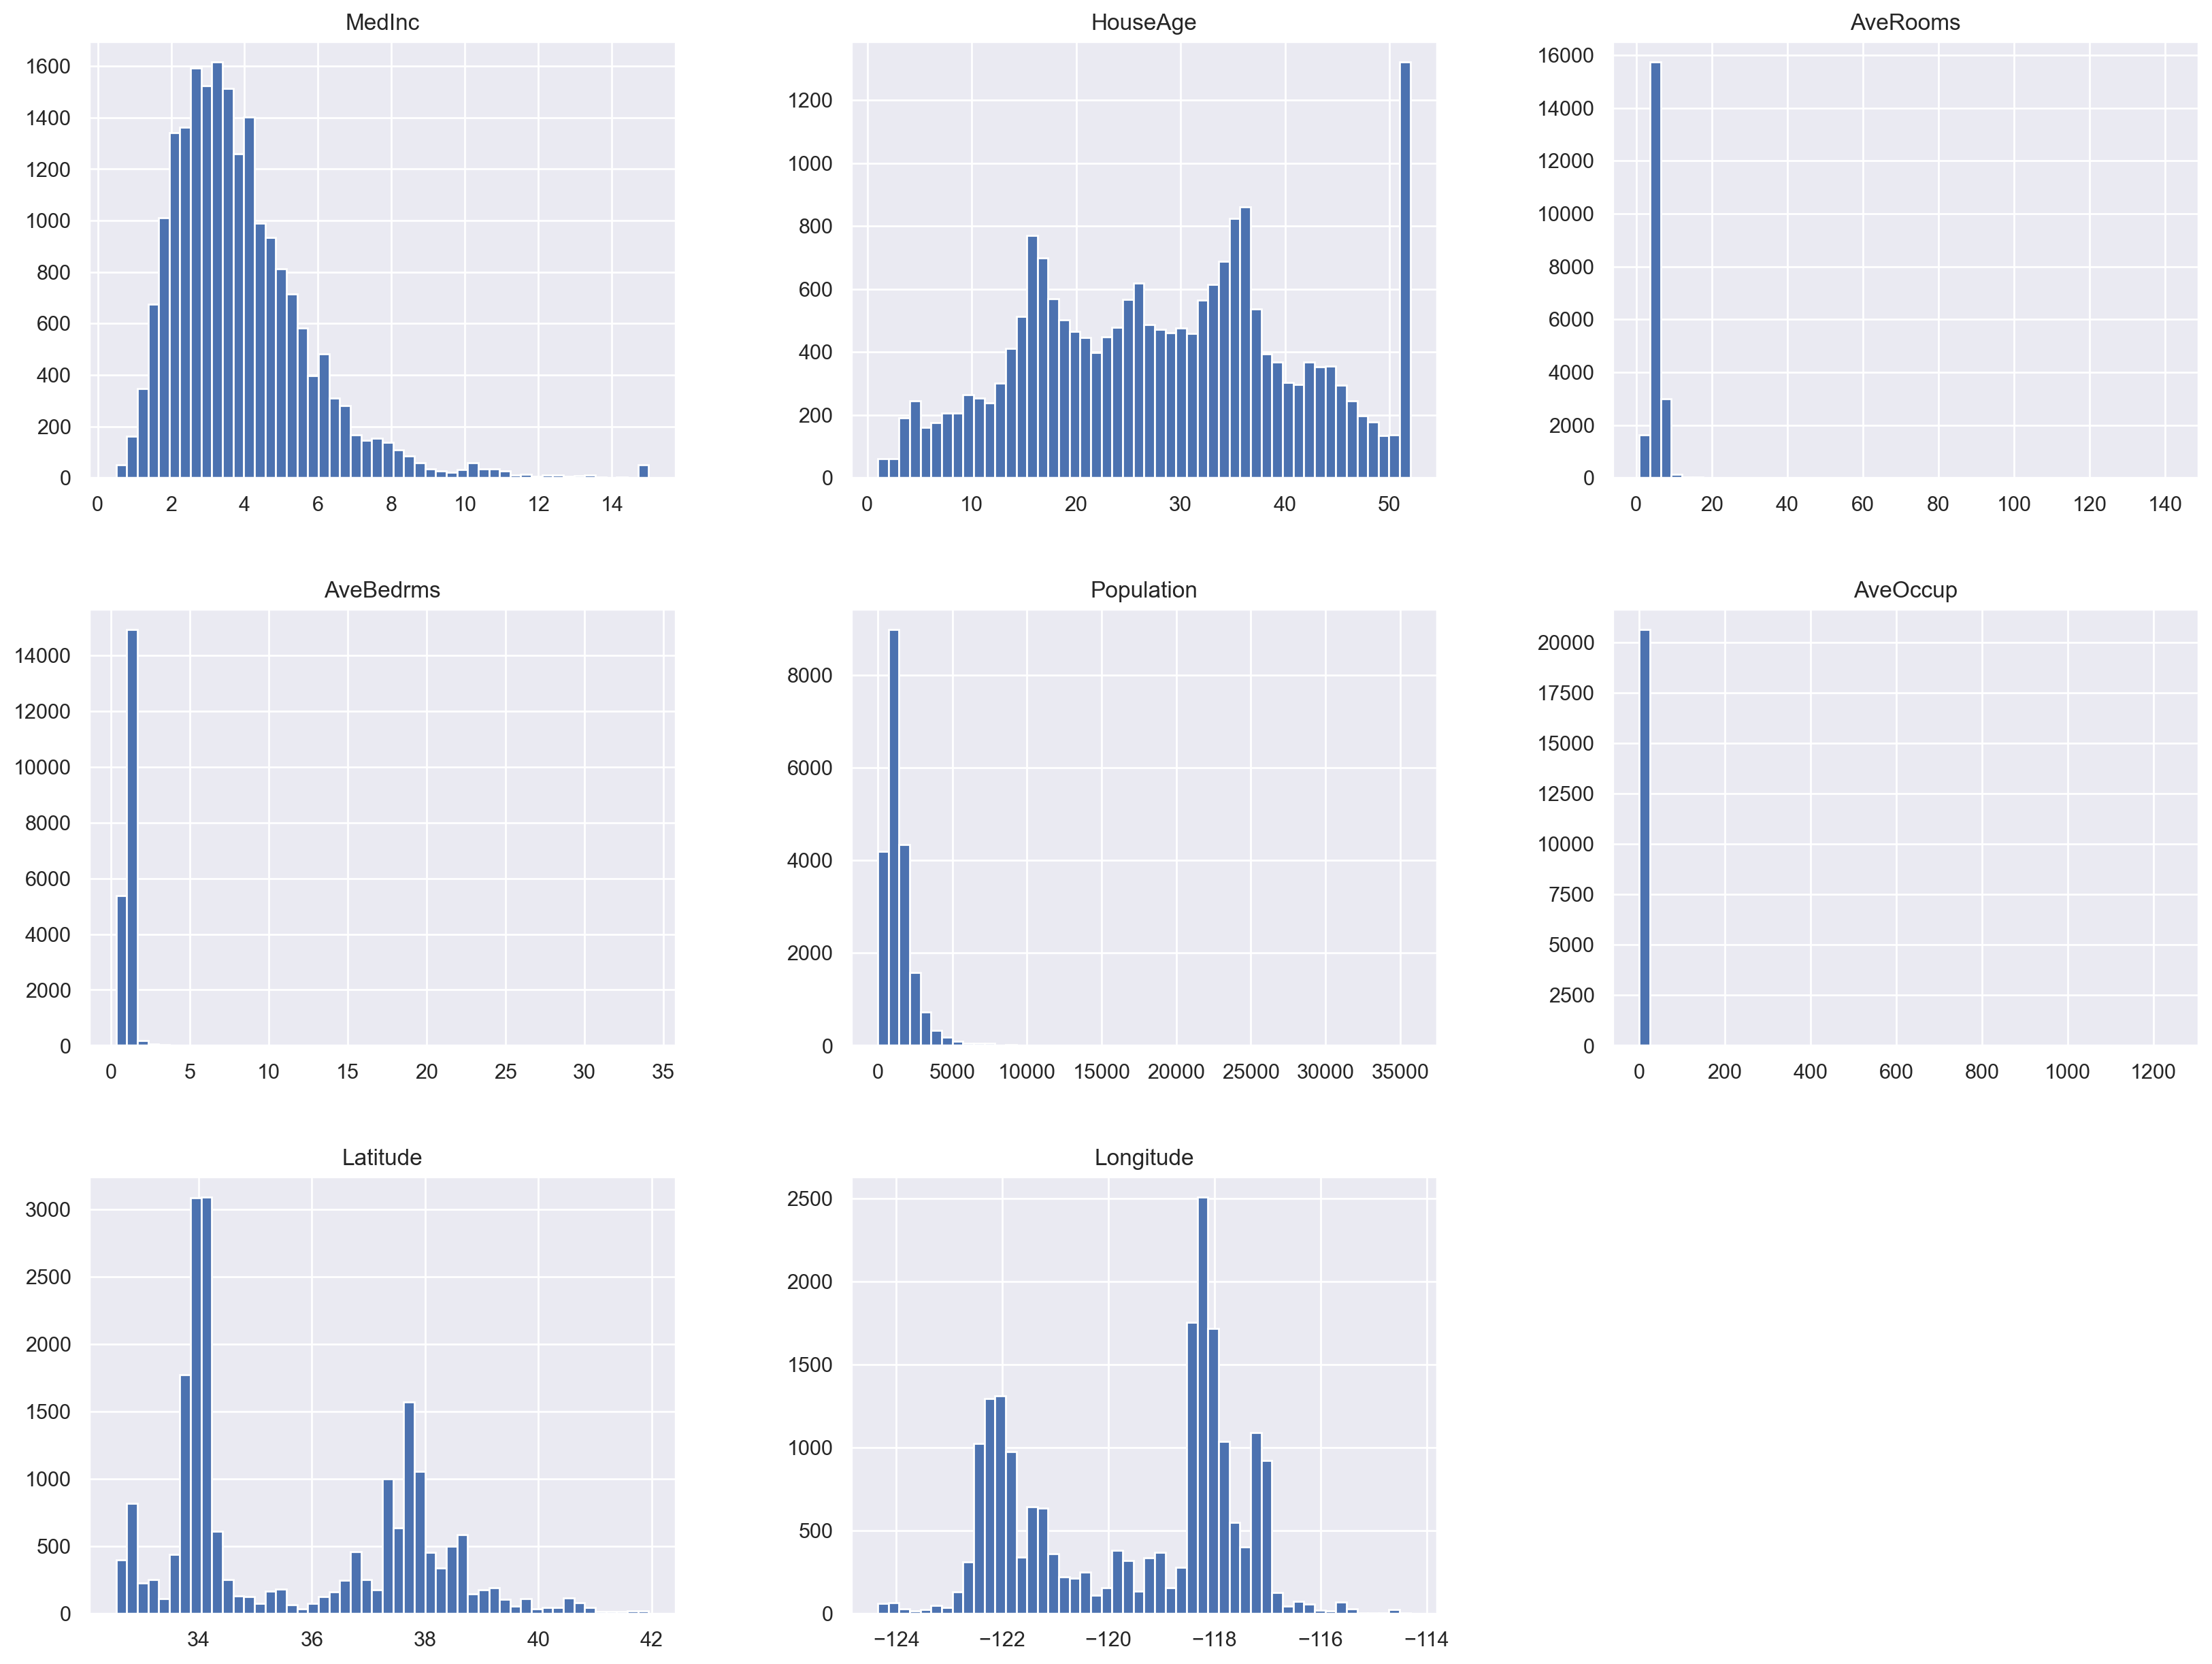

In [14]:
# make histograms of all predictors

X_df.hist(bins = 50, figsize=(20,15))
plt.show()

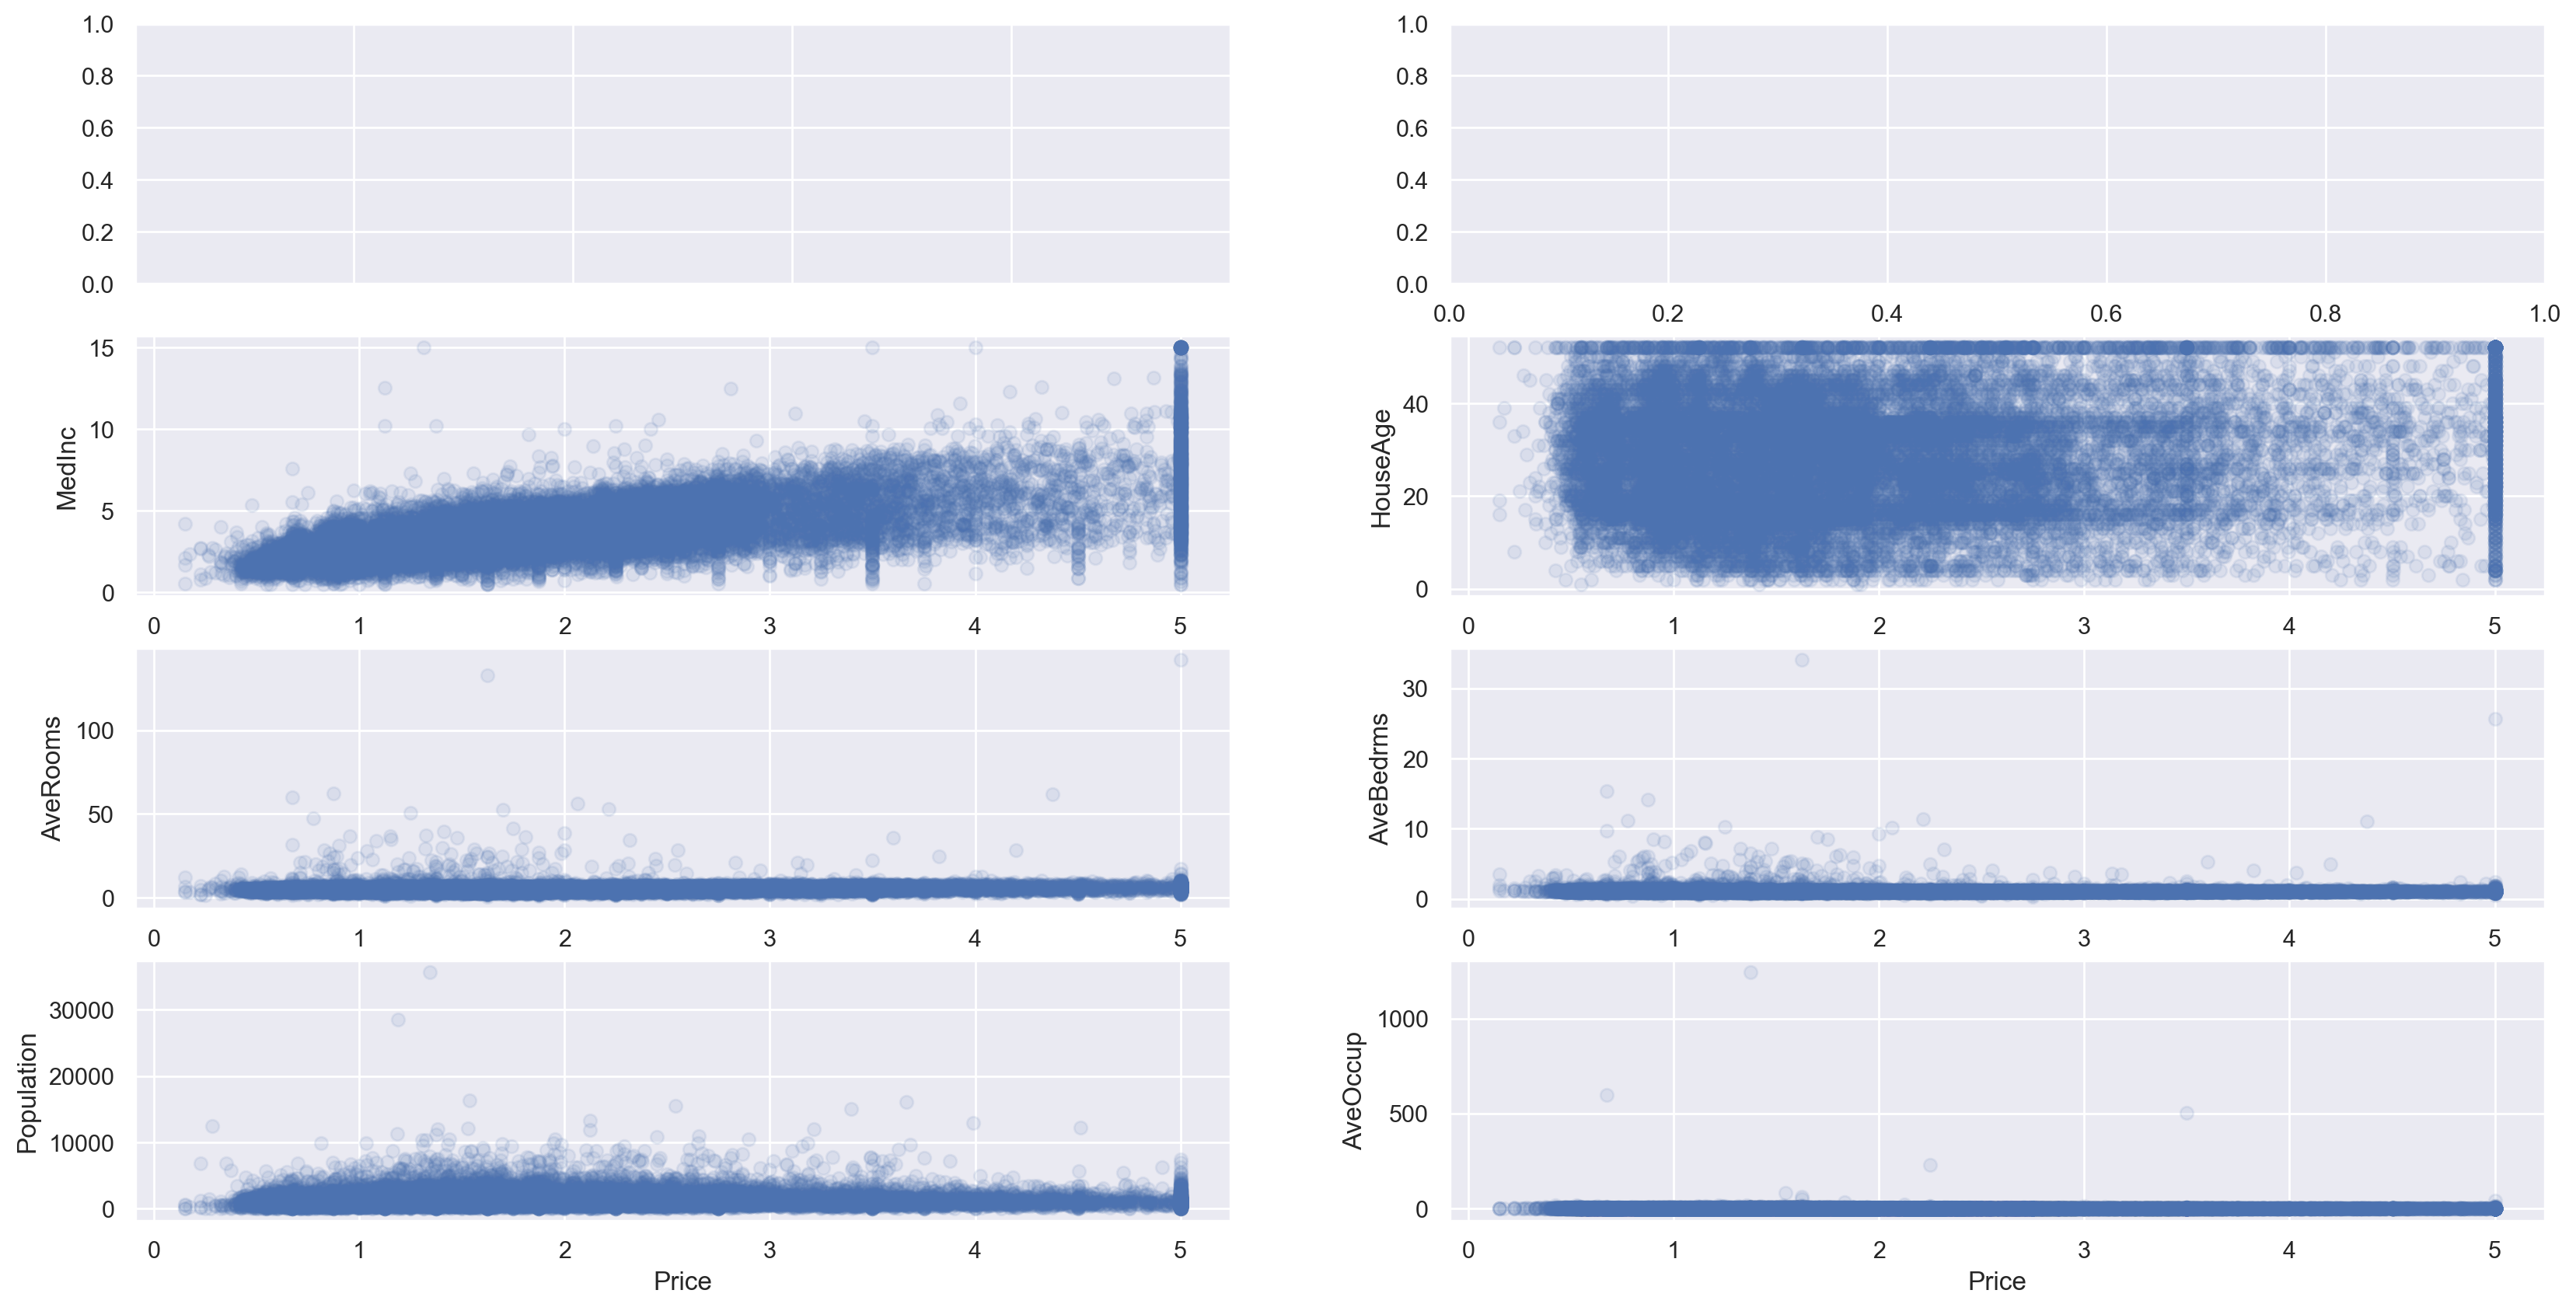

In [15]:
from seaborn import scatterplot
# make scatterplots of all predictors with the label

fig, ax = plt.subplots(4, 2, figsize=(20,10))
axe = ax.ravel()
axe[0].set_xticklabels([])
axe[0].set_xlabel(' ')
for i, feature_name in zip(range(1,7), X_df.columns):
    axe[i+1].scatter(y_full, X_df[feature_name], alpha=0.1)
    axe[i+1].set_xlabel('Price')
    axe[i+1].set_ylabel(feature_name)

# Train/Test Split

In [16]:
# Drop observations with price >= 5 (right censure)

mask = y_full<5
y_full=y_full[mask==True]
X_full=X_full[mask==True]
X_df=X_df[mask==True]

In [17]:
from sklearn.model_selection import train_test_split
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=0.2, random_state=1)

# Pre-Processing

In [18]:
from sklearn.preprocessing import StandardScaler
# produce standardized predictors with mean zero and variance one 
# fit the transformer in the training set and apply to the whole data

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)
X_full_scaled = scaler.transform(X_full)


In [19]:
from sklearn.preprocessing import PolynomialFeatures
# produce quadratic polynomial features from all standardized predictors
# squared values and pairwise interactions 
# fit the transformer in the training set and apply to the whole data

poly_features=PolynomialFeatures(degree=2)
X_train_poly=poly_features.fit_transform(X_train_scaled)
X_test_poly=poly_features.fit_transform(X_test_scaled) 
X_full_poly=poly_features.fit_transform(X_full_scaled) 


## Fractional Ridge Regression

https://arxiv.org/abs/2005.03220

https://nrdg.github.io/fracridge/

https://nrdg.github.io/fracridge/index.html 

In [ ]:
# !conda install fracridge
# %conda install fracridge
# this did both not work -> used pip install fracridge 

In [49]:
from fracridge import FracRidgeRegressorCV
from sklearn.metrics import mean_squared_error, r2_score
frcv = FracRidgeRegressorCV()

In [51]:
# train fractional ridge on raw predictors
# report the chosen fraction penalty
# report MSE and r-squared in test set 

frcv.fit(X_train, y_train)
print("fraction penalty: %s" % frcv.best_frac_)
y_test_pred_raw = frcv.predict(X_test)        
test_mse_raw = mean_squared_error(y_test, y_test_pred_raw)
test_rmse_raw = np.sqrt(test_mse_raw)
print("test RMS: %s" % test_rmse_raw) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred_raw), 2)) 

fraction penalty: 1.0
test RMS: 0.6739184430175053
test R2: 0.52


In [54]:
# train fractional ridge on stanardized predictors
# report the chosen fraction penalty
# report MSE and r-squared in test set 

frcv.fit(X_train_scaled, y_train)
print("fraction penalty: %s" % frcv.best_frac_)
y_test_pred_scaled = frcv.predict(X_test_scaled)        
test_mse_scaled = mean_squared_error(y_test, y_test_pred_scaled)
test_rmse_scaled = np.sqrt(test_mse_scaled)
print("test RMS: %s" % test_rmse_scaled) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred_scaled), 2)) 

fraction penalty: 0.6
test RMS: 2.0294864278300677
test R2: -3.35


In [56]:
# train fractional ridge on standardized predictors including quadratics and interactions
# report the chosen fraction penalty
# report MSE and r-squared in test set 

frcv.fit(X_train_poly, y_train)
print("fraction penalty: %s" % frcv.best_frac_)
y_test_pred_poly = frcv.predict(X_test_poly)        
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
test_rmse_poly = np.sqrt(test_mse_poly)
print("test RMS: %s" % test_rmse_poly) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred_poly), 2)) 

fraction penalty: 0.5
test RMS: 0.7294023044668323
test R2: 0.44


In [57]:
from seaborn import regplot

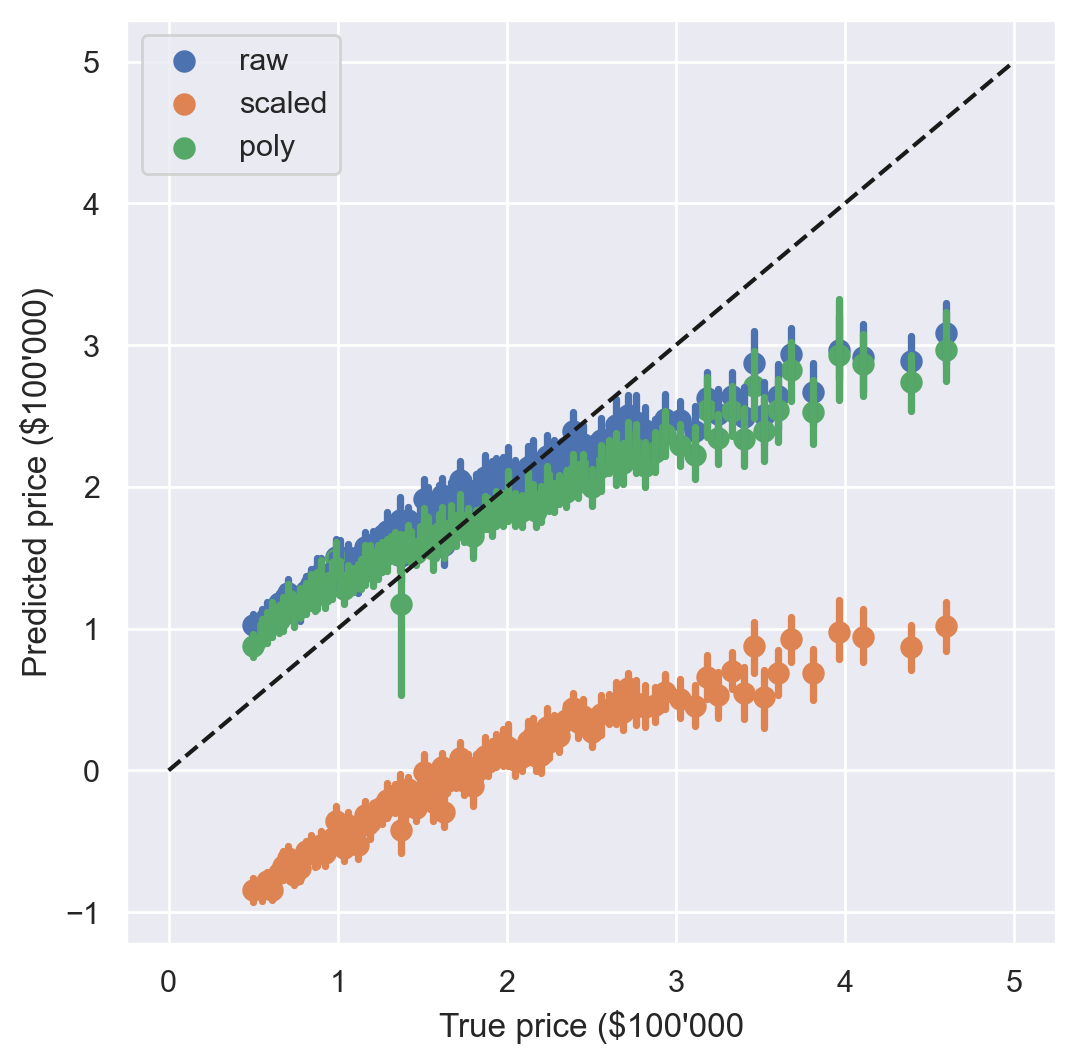

In [61]:
# report a binned regplot of the true outcome versus predictions in the test set

# create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# add the plots for each method
sns.regplot(x=y_test, y=y_test_pred_raw, x_bins=100, fit_reg=False, ax=ax, label='raw')
sns.regplot(x=y_test, y=y_test_pred_scaled, x_bins=100, fit_reg=False, ax=ax, label='scaled')
sns.regplot(x=y_test, y=y_test_pred_poly, x_bins=100, fit_reg=False, ax=ax, label='poly')
ax.set(ylabel="Predicted price ($100'000)", xlabel="True price ($100'000)")
ax.legend()
plt.plot([0, 5], [0, 5], '--k')
plt.show()

**How do the results change when using different predictors? Which one do you think is the best model for this task? Explain.**

When using the scaled predictors, the predicted price is systematically too low. But also using the raw predictors or the scaled polynomial predictors do not perform very well, they systematically overpredict low prices and underpredict high prices. Given the results from the RMSE and the R^2, the model with raw predictors performs best here.